
I am looking to solve a fresh challenge released by Quora using : 
1. existing neural-net models 
* state-of-art techniques (specifically a recent paper from Google (https://arxiv.org/pdf/1606.01933.pdf ) where they use a novel attention model which performs very well on SNLI task)

**Data**: Quora duplicate questions dataset (400K question-pairs) - https://data.quora.com/First-Quora-Dataset-Release-Question-Pairs

**Problem**: Given a pair of sentences $s_1, s_2$; predict whether they are duplicate or not (binary response). 

I could treat this as an NLI problem and could try to predict a binary (*E/N*) NLI label or tertiary(*E/N/C*) NLI class label over the pair of sentences. In tertiary case, I could add another layer to get a binary response or do some thresholding.

NLI setting:
1: entailment
0: neutral


**Initial Data Visualization ( *Figure 1*)**: 

I train and visualize word-vectors on the question-corpus to understand and get friendly with Quora data. Specifically, I build a graph (words as nodes and similarity as edge-weights) and extract strongest connected components. 

You'll notice a lot of components relevant to Indian demographic (India is >40% of user-base) - for example, the recent 'demonetization of currency notes in India' is a subgraph.

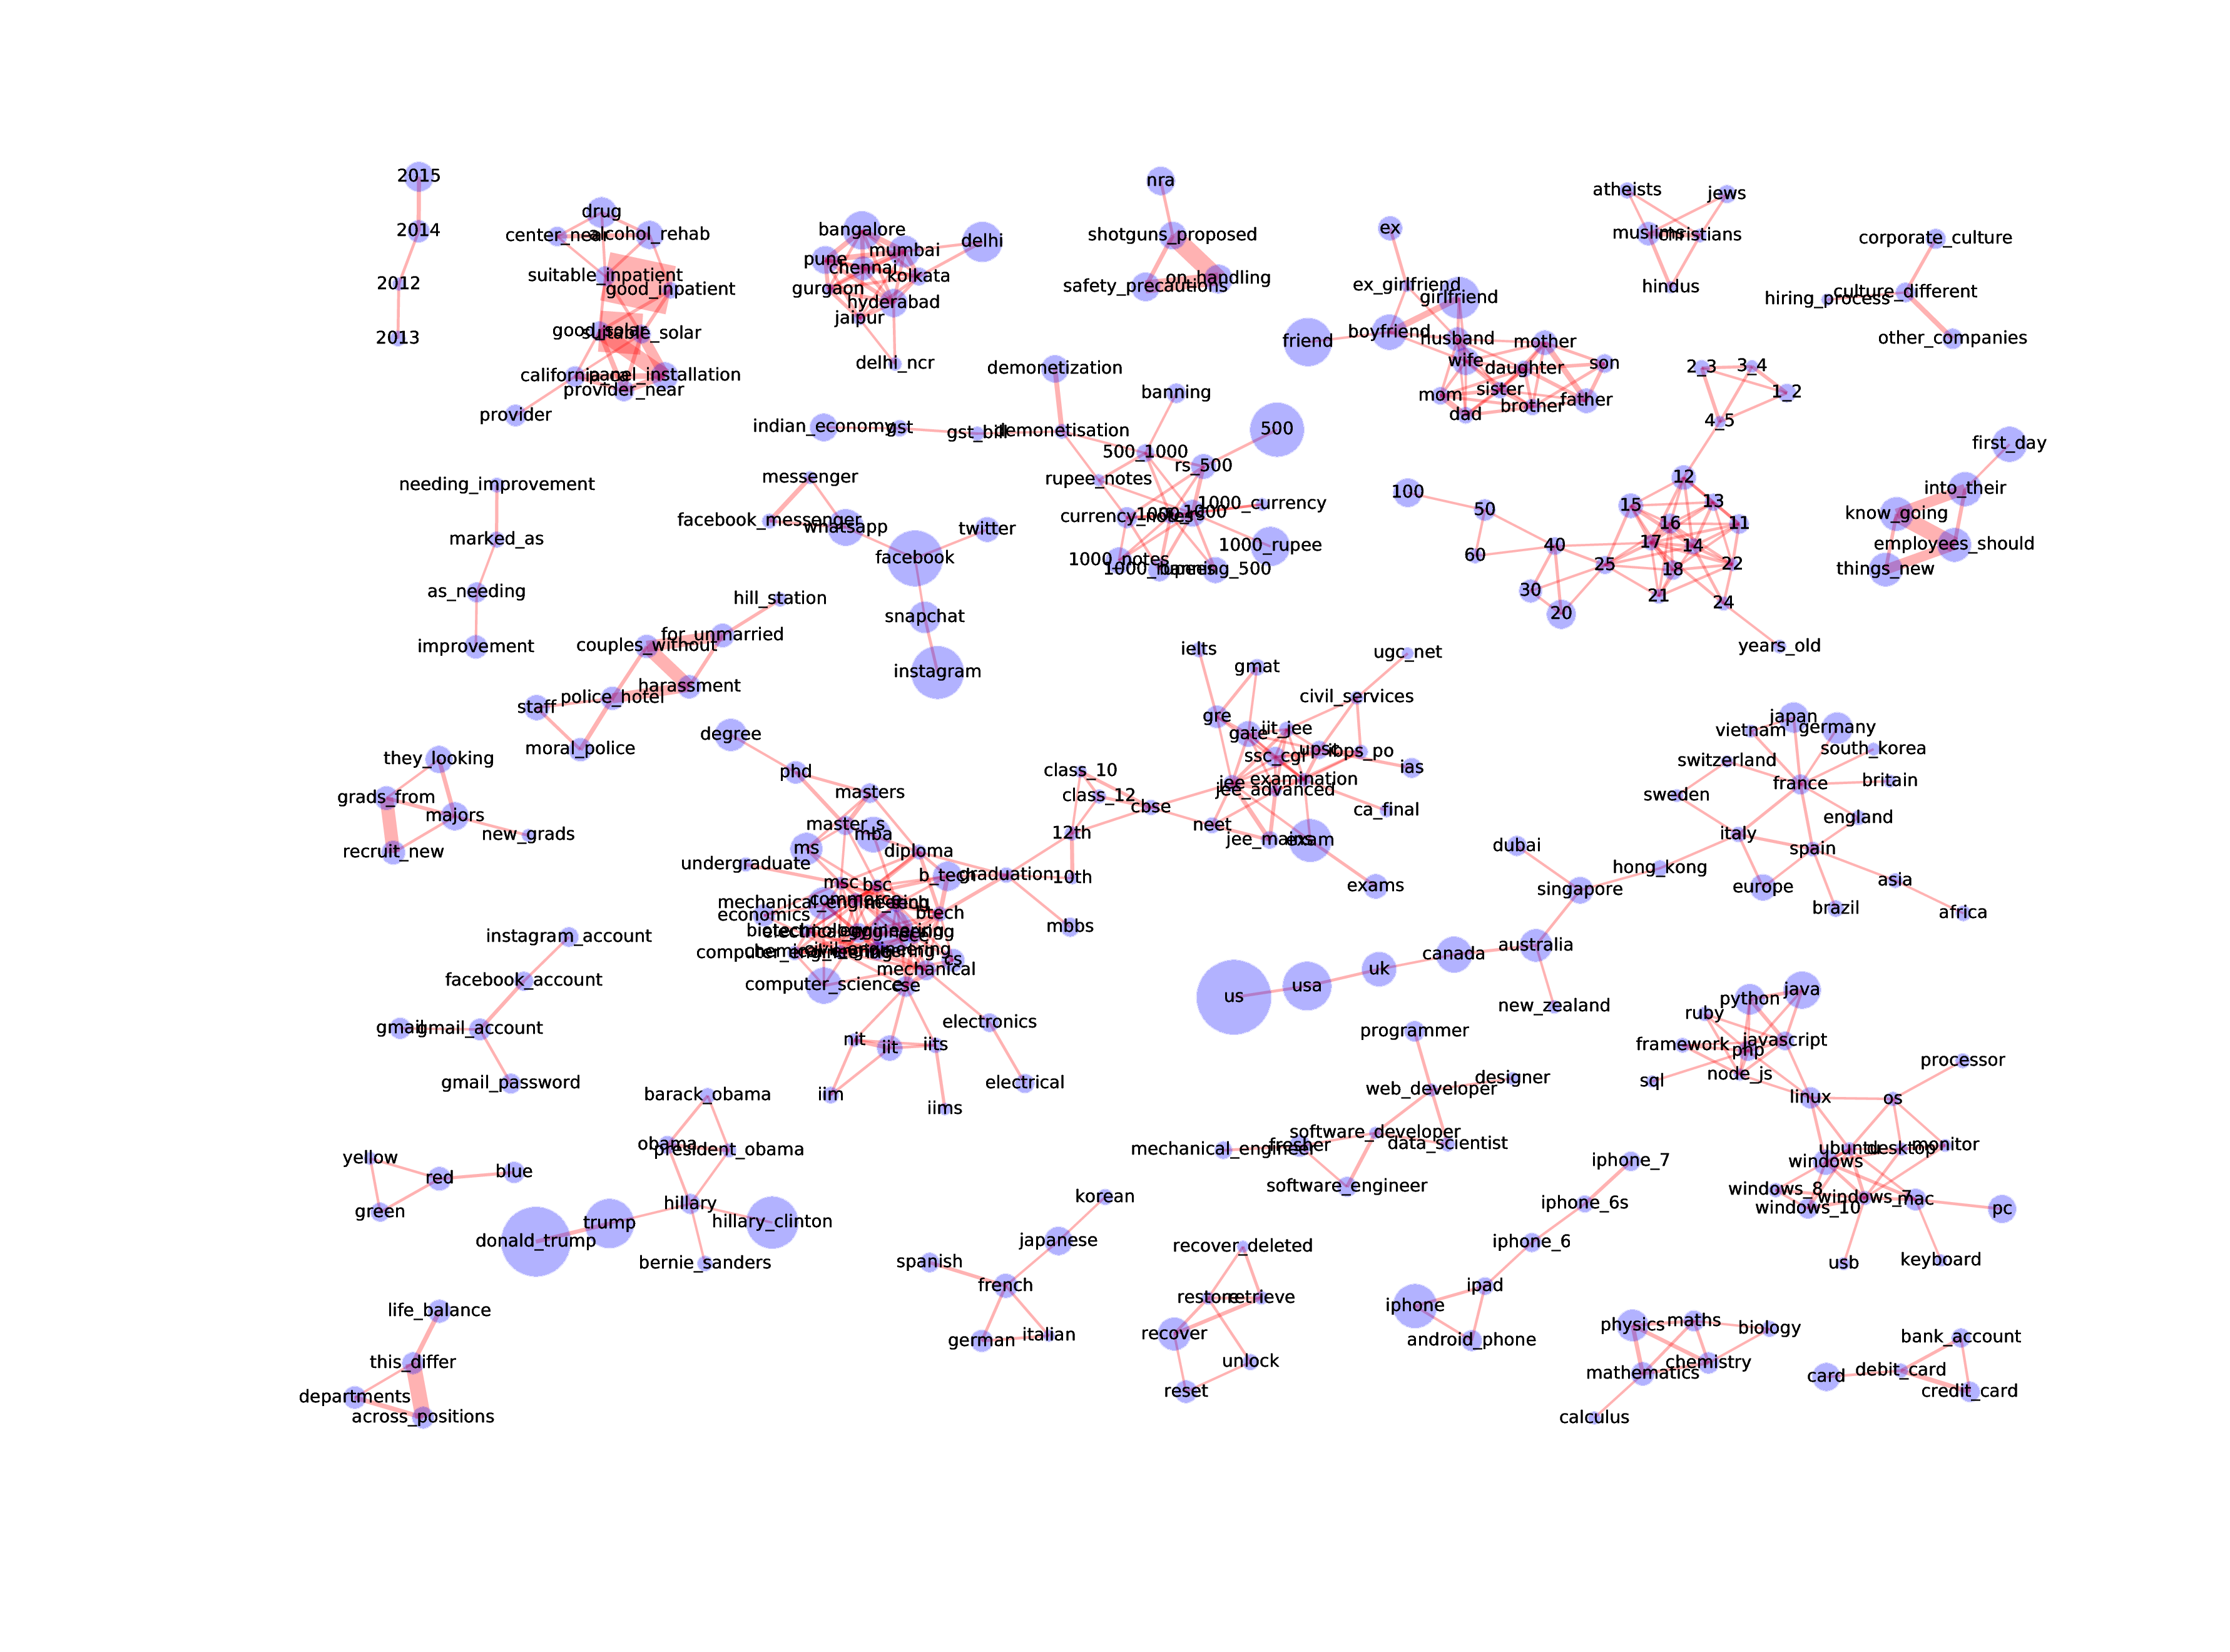

In [21]:
#Figure 1. Strongly connected words (node-size proportional to count, edge-thickness proportional to 1/cosine-distance)
img = WImage(filename='/Users/tarun/nlp/word2vec/plots/full.pdf', resolution = 500); img

**Model 0.  Bag-of-words**:

I download Google's word2vec and transform sentences to BOW-averaged vectors ($d$-dimensional). I am only using "static" word-vectors and don't re-train the word-vectors (I only used the learnt vectors for visualization). This is in light of discussion on "how re-training word-vectors can lead to loss in generalization."

I end-up with vector-representations of individual sentences.

*Feature-stack*

To capture the relatedness and similarity of the sentence-pairs, I combine the vector representations in various ways to come up with our input-layer. Mathematically, our input-layer includes a concatenation of the input vectors $[s_1 ; s_2]$. 

In addition, I introduce secondary features to capture the similarity of sentences:
* $s_1 - s_2$
* $s_1 + s_2$
* $s_1 \circ s_2$
* $\text{Euclidean}(s_1, s_2)$
* $\text{Manhattan}(s_1, s_2)$
* $\text{Cosine} (s_1, s_2)$
* $\text{MinMax}(s_1, s_2)$

The key step seems to be adding the interaction terms which gives us significant performance boost. Given this $4d+4$ -dimensional input layer,  I predict output y ('entailment' :1, 'neutral': 0).

I do a 80-10-10 (train-dev-test split) split on 400K examples. 

I try a variety of models including a first neural-net model. It is simple but turns out to be very effective. Some architectural details:
* two-hidden layers 
* one dropout layer sandwiched between two-hidden layers
* hyperparameters: #neurons1, #neurons2, dropout-ratio, epoch, batch

*Hyperparameter tuning*: I identify best hyper-parameters via bayesian-optimization (uses UCB to explore-exploit the hyperparameter-space) that maximize cross-validation performance on a training-set.

*Table 1* and *Figure 2* shows the performance of different models on the dev-set across different classic classification metrics/curves. Neural-net is winning!!


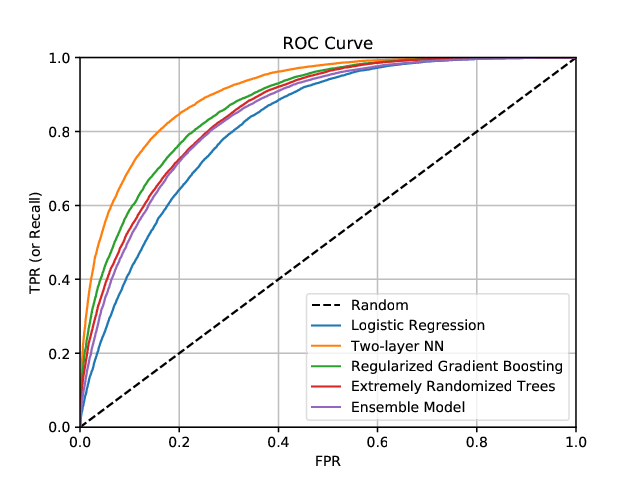

In [22]:
#Figure 2.  Model evaluation curves 
img = WImage(filename='/Users/tarun/nlp/results/full_model_roc20170206-231253.pdf', resolution = 100); img

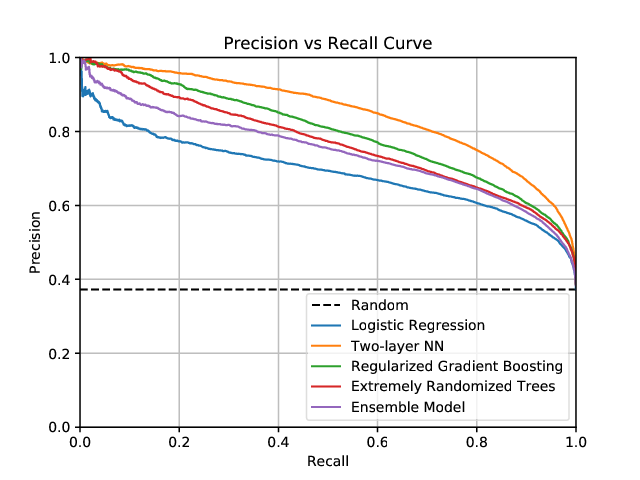

In [19]:
img = WImage(filename='/Users/tarun/nlp/results/full_model_RP20170206-231254.pdf', resolution = 100); img

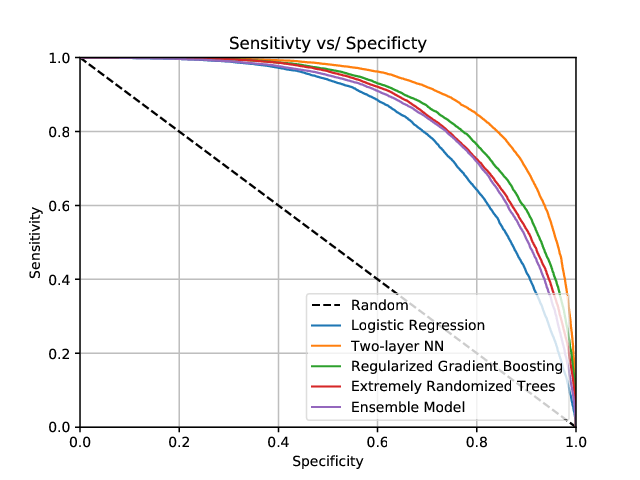

In [23]:
img = WImage(filename='/Users/tarun/nlp/results/full_model_spc20170206-231254.pdf', resolution = 100); img

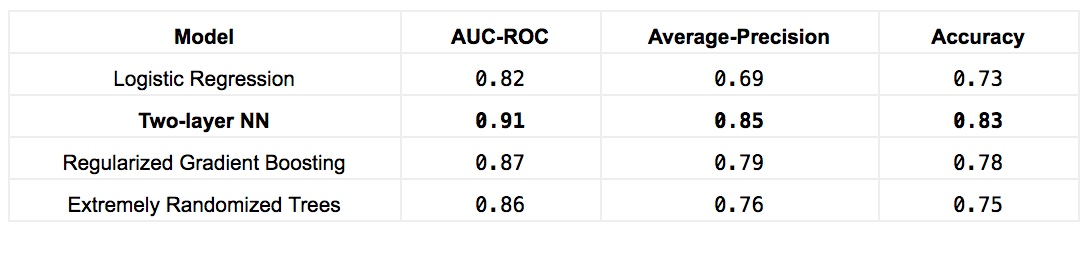

In [29]:
#Table 1. Performance comparison of different models on the Quora task
from IPython.display import Image
Image(filename='perf.jpeg') 

**Error Analysis**

I also started a preliminary analysis of errors committed by current best model to identify deficiencies and potential improvements of our approach.

Here are some mistakes made by our model (*Table 2*) in order of frequency:
(most common) Partial entailment is tricky! Quora has labelled partial entailment as 1 is some cases and 0 in other cases
Complex semantics not being captured (which makes sense since I don't account for ordering etc. and roll-back semantics into a single vector)
Number representations
Grammar mistakes by users (I need to soften the penalty)
Finally, I split the predictions into two-sets ('error' and 'no-error' set and identify the trends across these two sets).

1. It looks like I am making more mistakes on small sentences (the median length in 'error' set if only 48 compared to 54 in 'no-error' set)
2. I can also break-down errors by question-type (see *Table 3*). There are no clear trends here.



**Next Steps**

1. Try basic models
* Try data augmentation for regularization(similar to images where I randomly crop, rotate images and add them to training-set) to improve generalization performance of the model. I could replace words in sentence with most_similar word and/or crop sentences to add additional examples. This could help with grammar and partial entailment issues above.
*  Google paper: A key idea in the Google paper is that instead of reducing sentences to vectors in isolation, their novel attention mechanism soft-aligns the two sentence matrices (to come up with a heat-map like alignment matrix) and then mix these to arrive at the final vector.

So, they are doing pair2vec instead of sentence2vec which seems very-appropriate for this problem.

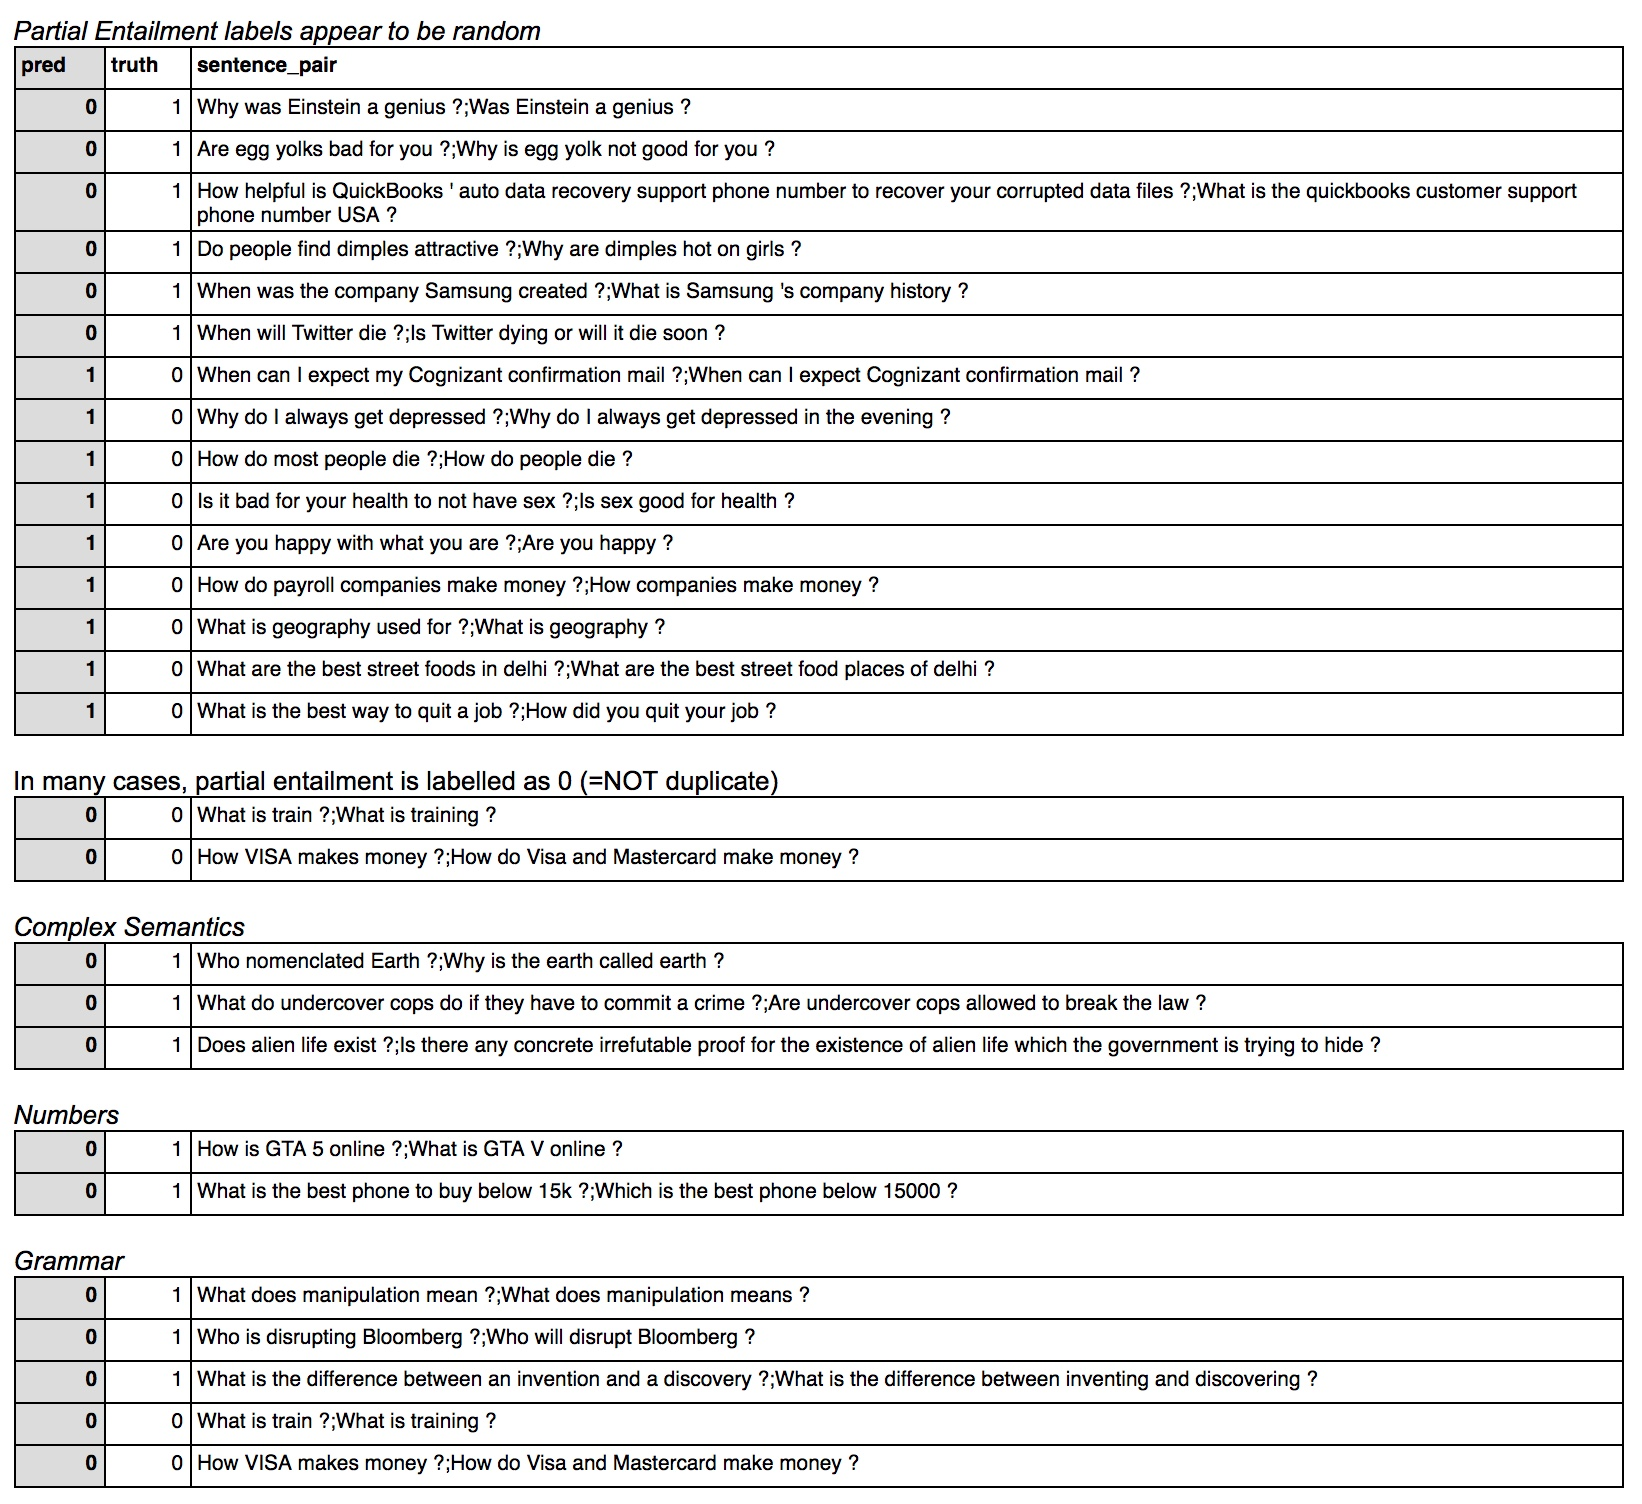

In [30]:
#Table 2. Error Analysis
Image(filename='error.jpeg')

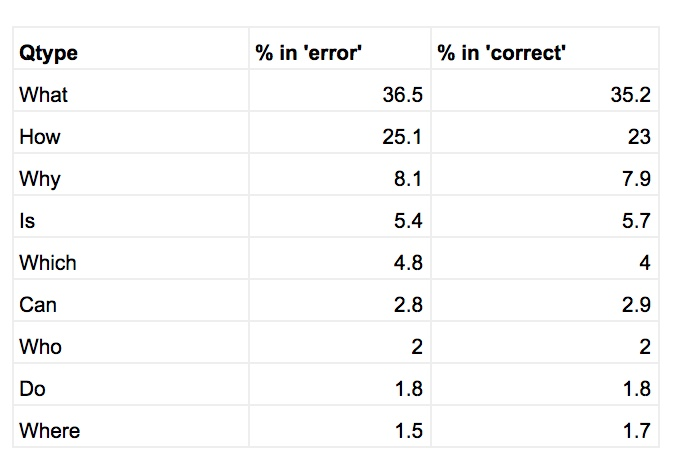

In [28]:
#Table 3. Break-down by question-type
Image(filename='qtype.jpeg') 